In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": [
        "Times New Roman",   # 如果存在，优先
        "Liberation Serif",  # Ubuntu / Debian 常见
        "Nimbus Roman",      # TeX / Ghostscript 常见
        "DejaVu Serif"       # Matplotlib 默认兜底
    ],
    "mathtext.fontset": "stix",       # 数学符号更像 Times
    "axes.unicode_minus": False,
})

In [2]:
ori = np.load('../Data-Driven Analysis/Result/DDPM + Gaussian Example 3/origin_data_unnorm_toyexample.npy')
genl = np.load('../Data-Driven Analysis/Result/DDPM + Gaussian Example 3/generate_data_unnorm_toyexample.npy')
genh = np.load('../Data-Driven Analysis/Result/DDPM + Student-t Example 3/generate_data_unnorm_toyexample.npy')

### Overall Distribution / Tail Distribution

In [3]:
def percentile_rank_from_top(x, v):
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[..., 0]
    x = x.reshape(-1)

    x = x[np.isfinite(x)]
    if x.size == 0:
        raise ValueError("Input array contains no valid numbers.")

    pct_top = 100.0 * np.mean(x >= v)
    return pct_top

def value_from_top_percent(x, top_pct):
    """
    x : array-like, shape (N,T,1) or (N,T)
    top_pct : float in (0,100]
              例如 2.5 表示 top 2.5%

    return:
        v : float
            满足约 top_pct% 的样本 >= v
    """
    if not (0 < top_pct <= 100):
        raise ValueError("top_pct must be in (0, 100].")

    x = np.asarray(x)
    if x.ndim == 3:
        x = x[..., 0]
    x = x.reshape(-1)

    x = x[np.isfinite(x)]
    if x.size == 0:
        raise ValueError("Input array contains no valid numbers.")

    # top p%  <=>  bottom (100-p) percentile
    q = 100.0 - float(top_pct)
    v = np.percentile(x, q)
    return float(v)

In [4]:
def _flatten_nt1(x):
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[..., 0]
    return x.reshape(-1).astype(np.float64)

def _lighten_color(color, amount=0.55):
    import matplotlib.colors as mc
    c = np.array(mc.to_rgb(color), dtype=np.float64)
    white = np.ones_like(c)
    out = (1.0 - amount) * c + amount * white
    return tuple(out)

def plot_flatten_pdf_hist(
    ori, genl, genh,
    bins=120,
    clip_quantile=(0, 1),
    alphas=(0.55, 0.55, 0.55),
    logy=False,
    title="Flattened Distribution (count)",
    xlabel="Value",
    ylabel="Count",
    savepath=None,
    dpi=300,
    ori_color="tab:blue",
    genl_color="tab:orange",
    genh_color="tab:green",
    lighten_gen=False,
    lighten_amount=0.60,
    linewidth=2.6,            # 线宽（新增，不影响其他逻辑）
    step_where="post",         # step 线对齐方式
):
    x_ori  = _flatten_nt1(ori)
    x_genl = _flatten_nt1(genl)
    x_genh = _flatten_nt1(genh)

    # 统一范围与 bins
    allx = np.concatenate([x_ori, x_genl, x_genh], axis=0)
    ql, qh = clip_quantile
    lo = np.quantile(allx, ql) if ql is not None else float(np.min(allx))
    hi = np.quantile(allx, qh) if qh is not None else float(np.max(allx))
    if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
        lo, hi = float(np.min(allx)), float(np.max(allx))

    edges = np.linspace(lo, hi, int(bins) + 1, dtype=np.float64)

    # 颜色（严格对齐 exceedance）
    ori_c = ori_color
    if lighten_gen:
        genl_c = _lighten_color(genl_color, amount=lighten_amount)
        genh_c = _lighten_color(genh_color, amount=lighten_amount)
    else:
        genl_c = genl_color
        genh_c = genh_color

    a_ori, a_genl, a_genh = alphas

    plt.figure(figsize=(8, 6))

    # =========================
    # 核心改动：hist -> 先算 count 再画 step 线
    # =========================
    c_ori,  _ = np.histogram(x_ori,  bins=edges, density=False)
    c_genl, _ = np.histogram(x_genl, bins=edges, density=False)
    c_genh, _ = np.histogram(x_genh, bins=edges, density=False)

    # 用 bin 边界画 step：y 需要补一个末尾点来对齐 edges 长度
    y_ori  = np.r_[c_ori,  c_ori[-1]]
    y_genl = np.r_[c_genl, c_genl[-1]]
    y_genh = np.r_[c_genh, c_genh[-1]]

    plt.step(edges, y_ori,  where=step_where, label="Original Data",
             color=ori_c,  alpha=a_ori,  linewidth=linewidth)
    plt.step(edges, y_genl, where=step_where, label="Diff (Vanilla)",
             color=genl_c, alpha=a_genl, linewidth=linewidth)
    plt.step(edges, y_genh, where=step_where, label="Diff (Value)",
             color=genh_c, alpha=a_genh, linewidth=linewidth)

    if logy:
        plt.yscale("log")

    plt.xlabel(xlabel, fontsize=40)
    plt.ylabel(ylabel, fontsize=40)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    plt.legend(loc="upper right",bbox_to_anchor=(1.05, 1.05),fontsize=30)

    plt.xlim(-0.25, 1.0)
    plt.ylim(0,30000)

    ax = plt.gca()
    ax.set_xticks(
        [-0.2, 0, 0.35, 0.6, 0.8, 1.0],
        ['-0.2', '0', '0.35', '0.6', '0.8', '1.0']
    )
    ax.set_yticks(
        [0,10000,20000,30000],
        ['0','10k','20k','30k']
    )

    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()

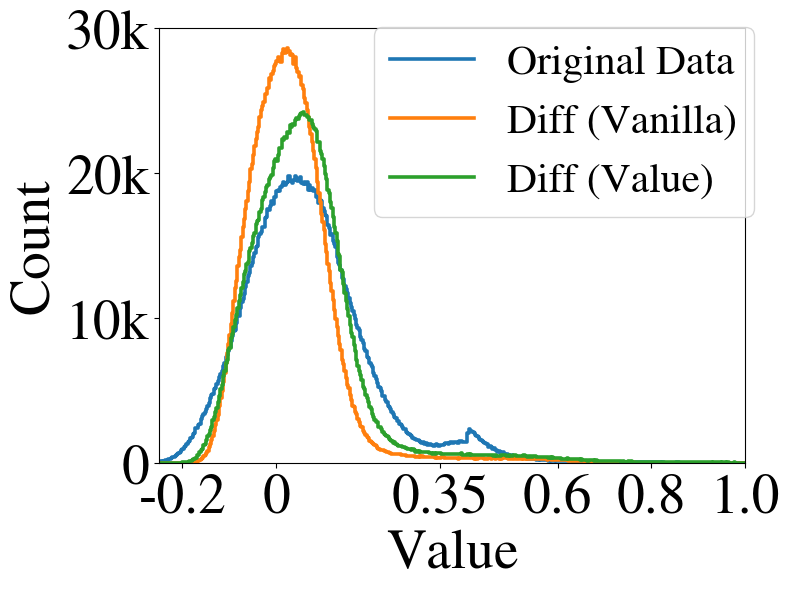

In [5]:
savepath = "../Data-Driven Analysis/Plot/Overall Distribution"
plot_flatten_pdf_hist(
    ori, genl, genh,
    bins=1000,
    alphas=(1, 1, 1),
    ori_color="tab:blue",
    genl_color="tab:orange",
    genh_color="tab:green",
    lighten_gen=False,    
    lighten_amount=0.60,    
    title="PDF Distribution",
    savepath = savepath,
)

In [6]:
def _flatten_nt1(x):
    x = np.asarray(x)
    if x.ndim == 3:
        x = x[..., 0]
    return x.reshape(-1).astype(np.float64)

def _ensure_u_tick(ax, u):
    ticks = list(ax.get_xticks())
    if not any(np.isclose(t, u) for t in ticks):
        ticks.append(float(u))
        ticks = sorted(ticks)
    ax.set_xticks(ticks)
    labels = []
    for t in ticks:
        if np.isclose(t, u):
            labels.append(f"{u:g}")
        else:
            labels.append(f"{t:g}")
    ax.set_xticklabels(labels)

def plot_exceedance_plot_1(
    series_dict,
    u=0.4,
    x_start=0.35,
    bins=60,
    x_max=None,
    xlim=None,
    title=None,
    xlabel="value",
    ylabel="count",
    alpha=1,
    savepath=None,
    dpi=300,
    colors=None,
    color_cycle=("tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"),
    linewidth=2.6,
):
    exc = {}
    for name, arr in series_dict.items():
        x = _flatten_nt1(arr)
        x = x[np.isfinite(x)]
        exc[name] = x[x >= float(u)]

    if xlim is not None:
        xmin, xmax = float(xlim[0]), float(xlim[1])
    else:
        xmin = float(x_start)
        all_exc = np.concatenate([v for v in exc.values() if v.size > 0], axis=0) \
                  if any(v.size > 0 for v in exc.values()) else np.array([u], dtype=np.float64)
        if x_max is None:
            xmax = float(np.max(all_exc))
            pad = 0.02 * max(1e-12, (xmax - xmin))
            xmax = xmax + pad
        else:
            xmax = float(x_max)

    if not np.isfinite(xmax) or xmax <= xmin:
        xmax = xmin + 1e-3

    edges = np.linspace(xmin, xmax, int(bins) + 1, dtype=np.float64)

    plt.figure(figsize=(8, 6))

    names = list(series_dict.keys())
    name2color = {}
    for i, name in enumerate(names):
        if isinstance(colors, dict) and (name in colors):
            name2color[name] = colors[name]
        else:
            name2color[name] = color_cycle[i % len(color_cycle)]

    for name in names:
        x = exc.get(name, None)
        if x is None or x.size == 0:
            continue

        cnt, _ = np.histogram(x, bins=edges, density=False)
        centers = 0.5 * (edges[:-1] + edges[1:])

        # ===== 核心修正：不画 0 count 的前缀段（避免 0.35 左侧/贴地线）=====
        # 1) 只保留 x>=x_start（防御性）
        m = (centers >= float(x_start))

        # 2) 去掉最前面连续为0的 bins，让曲线从“第一个非零 bin”开始
        nz = np.flatnonzero(cnt > 0)
        if nz.size > 0:
            first = int(nz[0])
            m &= (np.arange(cnt.size) >= first)
        else:
            continue  # 全0就不画

        plt.plot(
            centers[m], cnt[m],
            color=name2color[name],
            alpha=alpha,
            linewidth=linewidth,
            label=f"{name} (n={x.size})"
        )

    plt.axvline(float(u), color="black", linestyle="--", linewidth=2.0)
    plt.xlim(xmin, xmax)
    plt.ylim(0,900)

    ax = plt.gca()
    ax.set_xticks([0.35, 0.6, 0.8, 1.0, 1.2])
    ax.set_yticks([100, 300, 500, 700, 900])

    plt.xlabel(xlabel, fontsize=40)
    plt.ylabel(ylabel, fontsize=40)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)

    if title is None:
        title = f"Exceedances histogram (x ≥ {u})"
    # plt.title(title)
    # plt.legend()

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()


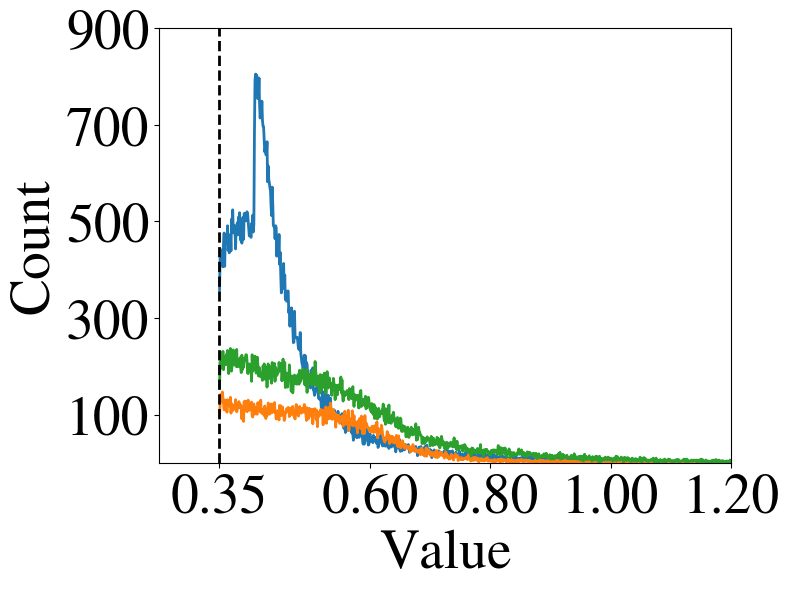

In [7]:
colors = {
    "ori":  "tab:blue",
    "genl": "tab:orange",
    "genh": "tab:green",
}

savepath = "../Data-Driven Analysis/Plot/Peak Distribution 035"
plot_exceedance_plot_1(
    {"ori": ori, "genl": genl, "genh": genh},
    u=0.35,
    bins=1000,
    xlim=(0.25, 1.2),
    xlabel="Value",
    ylabel="Count",
    colors = colors,
    savepath = savepath,
    linewidth=2.0,
)

In [8]:
def plot_exceedance_plot_2(
    series_dict,
    u=0.4,
    x_start=0.35,
    bins=60,
    x_max=None,
    xlim=None,
    title=None,
    xlabel="value",
    ylabel="count",
    linewidth=2.2,
    smooth=False,
    smooth_window=5,
    start_at_u=True,
    cut_by="center",
    savepath=None,
    dpi=300,
    colors=None,                 # <<< 新增：dict name->color
    color_cycle=("tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"),
):
    # 1) flatten + exceedances
    exc = {}
    for name, arr in series_dict.items():
        x = _flatten_nt1(arr)
        x = x[np.isfinite(x)]
        exc[name] = x[x >= float(u)]

    # 2) x-range
    if xlim is not None:
        xmin, xmax = float(xlim[0]), float(xlim[1])
    else:
        xmin = float(x_start)
        all_exc = np.concatenate([v for v in exc.values() if v.size > 0], axis=0) \
                  if any(v.size > 0 for v in exc.values()) else np.array([u], dtype=np.float64)
        if x_max is None:
            xmax = float(np.max(all_exc))
            pad = 0.02 * max(1e-12, (xmax - xmin))
            xmax = xmax + pad
        else:
            xmax = float(x_max)

    if not np.isfinite(xmax) or xmax <= xmin:
        xmax = xmin + 1e-3

    # 3) shared bins
    edges = np.linspace(xmin, xmax, int(bins) + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # 4) decide start index
    if start_at_u:
        if cut_by == "left":
            idx0 = int(np.searchsorted(edges[:-1], float(u), side="left"))
        else:
            idx0 = int(np.searchsorted(centers, float(u), side="left"))
        idx0 = max(0, min(idx0, len(centers)))
    else:
        idx0 = 0

    def _maybe_smooth(y):
        if not smooth:
            return y
        w = int(smooth_window)
        if w < 3:
            return y
        if w % 2 == 0:
            w += 1
        kernel = np.ones(w, dtype=np.float64) / float(w)
        pad = w // 2
        ypad = np.pad(y, (pad, pad), mode="edge")
        return np.convolve(ypad, kernel, mode="valid")

    plt.figure(figsize=(8, 6))

    # 颜色映射
    names = list(series_dict.keys())
    legendname = ['Original Data','Diff (Vanilla)','Diff (Value)']
    name2color = {}
    for i, name in enumerate(names):
        if isinstance(colors, dict) and (name in colors):
            name2color[name] = colors[name]
        else:
            name2color[name] = color_cycle[i % len(color_cycle)]

    name_num = 0
    for name in names:
        x = exc.get(name, None)
        if x is None or x.size == 0:
            continue

        counts, _ = np.histogram(x, bins=edges, density=False)
        counts = counts.astype(np.float64)

        c_centers = centers[idx0:]
        c_counts = counts[idx0:]
        c_counts = _maybe_smooth(c_counts)

        plt.plot(
            c_centers, c_counts,
            linewidth=linewidth,
            drawstyle="steps-mid",
            color=name2color[name],       # <<< 用颜色
            label=f"{legendname[name_num]}"
        )
        name_num += 1

    plt.axvline(float(u), color="black", linestyle="--", linewidth=2.0)
    plt.xlim(xmin, xmax)
    plt.ylim(0,83)

    ax = plt.gca()
    #_ensure_u_tick(ax, float(u))

    #plt.xlabel(xlabel,fontsize = 27)
    #plt.ylabel(ylabel,fontsize = 27)
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)

    ax = plt.gca()
    ax.set_xticks([0.6, 0.8, 1.0, 1.2]) 
    ax.set_yticks([0,20,40,60,80])
    
    if title is None:
        title = f"Exceedances (count) curve (x ≥ {u})"
    #plt.title(title)
    plt.legend(loc="upper right",bbox_to_anchor=(1.11, 1.10), fontsize=45)
    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()

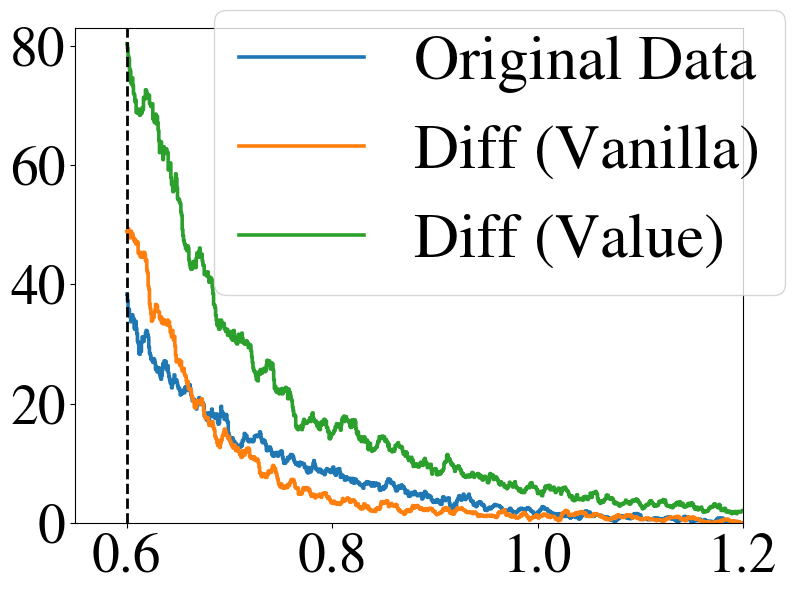

In [9]:
savepath = "../Data-Driven Analysis/Plot/Peak Distribution 080"
plot_exceedance_plot_2(
    {"ori": ori, "genl": genl, "genh": genh},
    u=0.6,
    bins=1000,
    xlim=(0.55, 1.2),
    xlabel="Value",
    ylabel="Count",
    start_at_u=True,
    cut_by="center",   # 推荐
    smooth=True,
    smooth_window=10,
    colors = colors,
    savepath = savepath,
    linewidth=2.6,
)

## Perspective of Extreme Theory

In [18]:
def _to_2d(X):
    X = np.asarray(X)
    if X.ndim == 3:
        X = X[:, :, 0]  # (N,L,1)->(N,L)
    if X.ndim != 2:
        raise ValueError(f"X must be (N,L) or (N,L,1), got {X.shape}")
    return X.astype(np.float32)

def extract_topk_per_series(X, top=2):
    """
    X: (N,L) or (N,L,1)
    Return:
      topk_flat: (N*top,) containing top-k values per series (descending within each series).
    """
    X = _to_2d(X)
    N, L = X.shape
    top = int(top)
    if top <= 0:
        raise ValueError("top must be >= 1")
    if L < top:
        raise ValueError(f"Sequence length L={L} is smaller than top={top}")

    topk = np.partition(X, kth=-top, axis=1)[:, -top:]   # (N,top)
    topk = np.sort(topk, axis=1)[:, ::-1]                # descending
    return topk.reshape(-1).astype(np.float64)           # (N*top,)


def plot_topk_hist_with_gev_overlay(
    ori, gen,
    top=2,
    bins=50,
    title=None,
    legend_labels=("ori", "gen"),          # <<< 新增：legend 名字接口
    colors=("tab:blue", "tab:orange"),     # <<< 新增：颜色接口（默认一致）
    alpha=0.55,
    linewidth=2.0,
    savepath = None,
):
    """
    - Extract top-k per series from ori and gen
    - Plot two histograms on same axes with SAME bins, counts (no density)
    - Fit GEV separately to ori and gen samples and overlay scaled PDF curves
    """
    ori_vals = extract_topk_per_series(ori, top=top)
    gen_vals = extract_topk_per_series(gen, top=top)

    ori_vals = ori_vals[np.isfinite(ori_vals)]
    gen_vals = gen_vals[np.isfinite(gen_vals)]
    if ori_vals.size < 10 or gen_vals.size < 10:
        raise ValueError(f"Too few samples: ori={ori_vals.size}, gen={gen_vals.size}")

    # shared equal-width bins from combined range
    allv = np.concatenate([ori_vals, gen_vals], axis=0)
    vmin, vmax = float(allv.min()), float(allv.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6
    edges = np.linspace(vmin, vmax, int(bins) + 1)
    bin_w = float(edges[1] - edges[0])

    lab_o, lab_g = legend_labels
    col_o, col_g = colors

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.hist(
        ori_vals, bins=edges, density=False, alpha=alpha,
        color=col_o,
        label=f"{lab_o}"
    )
    ax.hist(
        gen_vals, bins=edges, density=False, alpha=alpha,
        color=col_g,
        label=f"{lab_g}"
    )

    ax.set_xlabel(f"value (top-{top} per series)")
    ax.set_ylabel("count")
    if title is not None:
        ax.set_title(title)

    # GEV fit & overlay (scaled to counts)
    try:
        from scipy.stats import genextreme
    except Exception as e:
        raise ImportError("Need scipy for GEV fitting: pip install scipy") from e

    c_o, loc_o, scale_o = genextreme.fit(ori_vals)
    c_g, loc_g, scale_g = genextreme.fit(gen_vals)

    grid = np.linspace(vmin, vmax, 600)
    pdf_o = genextreme.pdf(grid, c_o, loc=loc_o, scale=scale_o)
    pdf_g = genextreme.pdf(grid, c_g, loc=loc_g, scale=scale_g)

    # scale pdf -> expected counts per bin
    y_o = pdf_o * bin_w * float(ori_vals.size)
    y_g = pdf_g * bin_w * float(gen_vals.size)

    ax.plot(
        grid, y_o,
        color=col_o, linewidth=linewidth,
        label=f"{lab_o} GEV"
    )
    ax.plot(
        grid, y_g,
        color=col_g, linewidth=linewidth,
        label=f"{lab_g} GEV"
    )

    
    plt.xlabel("Value", fontsize=30)
    plt.ylabel("Count", fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlim(0,1.5)

    ax.legend(loc="upper right",bbox_to_anchor=(1.05, 1.05),fontsize = 25)
    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"[{lab_o}] top={top} | xi={-float(c_o):.6g}, loc={float(loc_o):.6g}, scale={float(scale_o):.6g}")
    print(f"[{lab_g}] top={top} | xi={-float(c_g):.6g}, loc={float(loc_g):.6g}, scale={float(scale_g):.6g}")

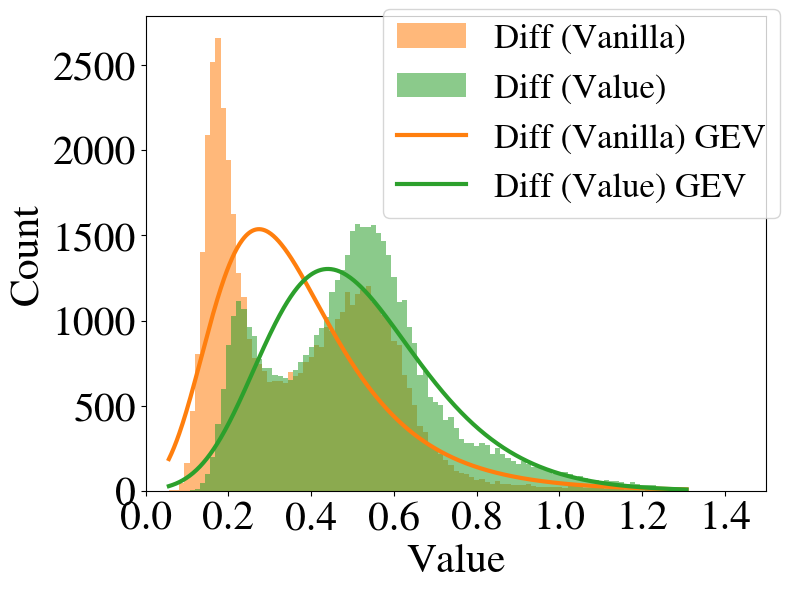

[Diff (Vanilla)] top=5 | xi=0.0476728, loc=0.280908, scale=0.14988
[Diff (Value)] top=5 | xi=-0.0971239, loc=0.422307, scale=0.177433


In [20]:
plot_topk_hist_with_gev_overlay(
    genl, genh,
    top=5, bins=100,
    legend_labels=("Diff (Vanilla)", "Diff (Value)"),
    colors=("tab:orange", "tab:green"),
    alpha=0.55, linewidth=3.0,
    title=None,
    savepath = "../Data-Driven Analysis/Plot/GEV Distribution for GD-SD"
)

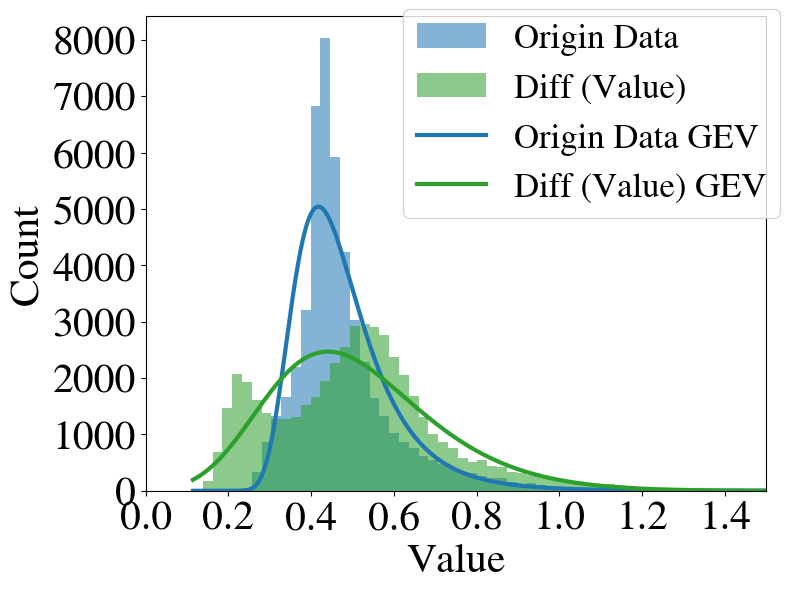

[Origin Data] top=5 | xi=0.0744311, loc=0.423553, scale=0.0867249
[Diff (Value)] top=5 | xi=-0.0971239, loc=0.422307, scale=0.177433


In [21]:
plot_topk_hist_with_gev_overlay(
    ori, genh,
    top=5, bins=100,
    legend_labels=("Origin Data", "Diff (Value)"),
    colors=("tab:blue", "tab:green"),
    alpha=0.55, linewidth=3.0,
    title=None,
    savepath = "../Data-Driven Analysis/Plot/GEV Distribution for OD-SD"
)

## Extreme Analysis (count as an example)

In [22]:
def plot_sample(origin_data, generated_data, num=8, channel=0,
                y_pad_ratio=0.05, n_yticks=6,
                u_global=None, u_label="u_global",
                mark_extremes=False,
                seed=None,
                sample_idx=None,
                savepath = None,):
    """
    origin_data:    (N, T, C)
    generated_data: (N, T, C)
    num:            抽样条数（默认 8），仅在 sample_idx=None 时生效
    channel:        可视化的特征维（默认 0）
    y_pad_ratio:    y 轴上下留白比例
    n_yticks:       y 轴刻度数量（两张图一致）
    u_global:       全局阈值线（标量）。超过该线视为极值
    u_label:        阈值线图例文本
    mark_extremes:  是否把超过阈值的点用散点标出来（可选）
    seed:           随机种子；None 表示每次调用都不同
    sample_idx:     指定样本下标列表/数组，例如 [0, 5, 12]。提供后将忽略 num/seed
    """
    origin_data = np.asarray(origin_data)
    generated_data = np.asarray(generated_data)

    N1, T1, C1 = origin_data.shape
    N2, T2, C2 = generated_data.shape

    if (T1 != T2) or (C1 != C2):
        raise ValueError(f"Shape mismatch: origin={origin_data.shape}, generated={generated_data.shape}")

    N = min(N1, N2)

    # ---- choose indices: either user-specified or random ----
    if sample_idx is not None:
        idx = np.asarray(sample_idx, dtype=np.int64).reshape(-1)
        if idx.size == 0:
            raise ValueError("sample_idx is empty.")
        if np.any(idx < 0) or np.any(idx >= N):
            raise ValueError(f"sample_idx out of range [0, {N-1}]. Got: {idx.tolist()}")
        # 去重但保持顺序
        _, first_pos = np.unique(idx, return_index=True)
        idx = idx[np.sort(first_pos)]
        num = int(idx.size)
    else:
        num = min(int(num), int(N))
        rng = np.random.default_rng(seed)
        idx = rng.choice(N, size=num, replace=False)

    x = np.arange(T1)

    y_all = np.concatenate([
        origin_data[idx, :, channel].reshape(-1),
        generated_data[idx, :, channel].reshape(-1)
    ], axis=0)

    if u_global is not None:
        u_global = float(u_global)
        y_all = np.concatenate([y_all, np.array([u_global], dtype=y_all.dtype)], axis=0)

    y_min = float(np.min(y_all))
    y_max = float(np.max(y_all))

    span = y_max - y_min
    if span < 1e-12:
        span = 1.0
    pad = span * y_pad_ratio
    y_min -= pad
    y_max += pad

    locator = MaxNLocator(nbins=n_yticks)

    def _add_threshold_line(ax):
        if u_global is None:
            return
        ax.axhline(
            u_global,
            color="black",
            linestyle="--",
            linewidth=2.6,   # 更粗更明显
            alpha=1.0,
            label='threshold'
        )

    def _mark_extreme_points(ax, y):
        if (u_global is None) or (not mark_extremes):
            return
        mask = (y > u_global)
        if np.any(mask):
            ax.scatter(x[mask], y[mask], s=14, marker="o", zorder=3)

    # -------- Figure 1: Origin --------
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    for k, i in enumerate(idx, start=1):
        y = origin_data[i, :, channel]
        ax1.plot(x, y, alpha=0.9, label=f"sample {k}")
        _mark_extreme_points(ax1, y)

    _add_threshold_line(ax1)

    #ax1.set_title(f"Random {num} samples | Origin (channel={channel})" if sample_idx is None
                 # else f"Selected {num} samples | Origin (channel={channel})")
    ax1.set_xlabel("Time index",fontsize = 30)
    ax1.set_ylabel("Value",fontsize = 30)
    ax1.tick_params(axis="x", labelsize=25)
    ax1.tick_params(axis="y", labelsize=25)
    ax1.set_ylim(y_min, y_max + 0.05)
    ax1.yaxis.set_major_locator(locator)
    ax1.legend(loc="upper right", bbox_to_anchor=(0.99, 1.17), fontsize = 25, ncol=3)
    fig1.tight_layout()
    
    if savepath is not None:
        plt.savefig(savepath + ' ori', dpi=300, bbox_inches="tight")
    
    plt.show()

    # -------- Figure 2: Generated --------
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    for k, i in enumerate(idx, start=1):
        y = generated_data[i, :, channel]
        ax2.plot(x, y, alpha=0.9, label=f"sample {k}")
        _mark_extreme_points(ax2, y)

    _add_threshold_line(ax2)

    #ax2.set_title(f"Random {num} samples | Generated (channel={channel})" if sample_idx is None
                 # else f"Selected {num} samples | Generated (channel={channel})")
    ax2.set_xlabel("Time index",fontsize = 30)
    ax2.set_ylabel("Value" ,fontsize = 30)
    ax2.tick_params(axis="x", labelsize=25)
    ax2.tick_params(axis="y", labelsize=25)
    ax2.set_ylim(y_min, y_max + 0.05)
    ax2.yaxis.set_major_locator(locator)
    ax2.legend(loc="upper right", bbox_to_anchor=(0.99, 1.17),fontsize = 25, ncol=3)
    fig2.tight_layout()

    if savepath is not None:
        plt.savefig(savepath + ' gen', dpi=300, bbox_inches="tight")
    
    plt.show()

    return idx

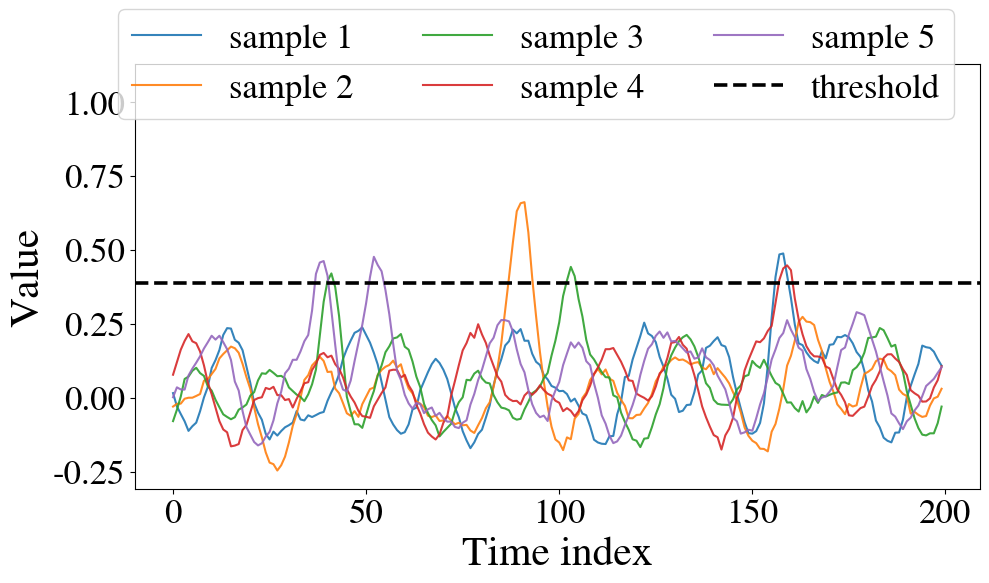

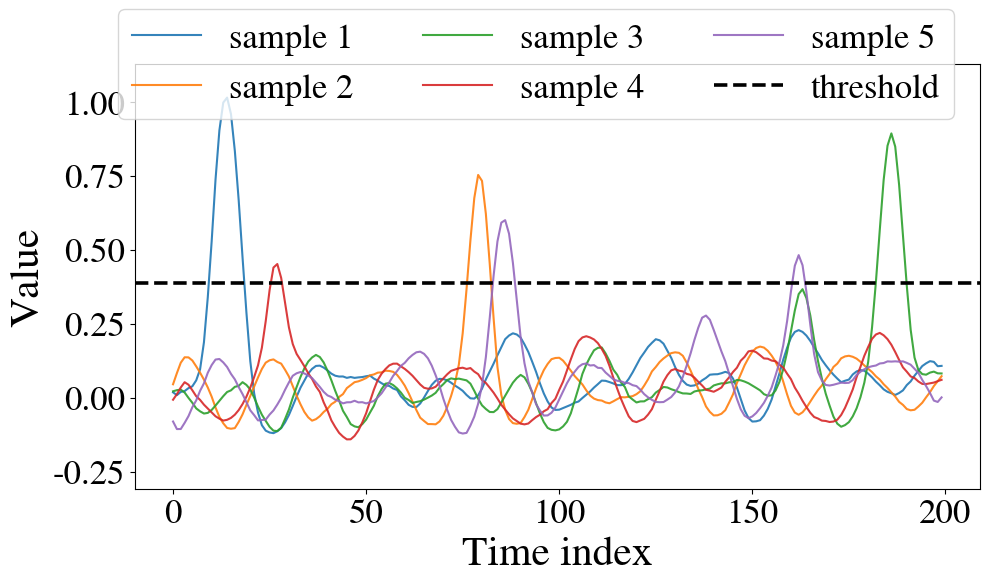

array([4032, 8329, 3784, 5081, 5006])

In [23]:
u_global = 0.3880803084373474
plot_sample(ori, genh, num=5, seed=None, u_global=u_global,savepath = "../Data-Driven Analysis/Plot/extreme visualization")

In [24]:
def extract_events_over_threshold(X, u, merge_gap=0, min_width=1):
    """
    Return exactly:
      peak_abs: (E,) absolute peak value per detected event
      widths:   (E,) event width (#points) per detected event
      cnt:      (N,) number of detected events per series

    X: (N,L,1) or (N,L)
    u: threshold
    merge_gap: merge segments whose gap <= merge_gap
    min_width: drop events with width < min_width
    """
    X = np.asarray(X)
    if X.ndim == 3:
        assert X.shape[-1] == 1
        x = X[:, :, 0]
    elif X.ndim == 2:
        x = X
    else:
        raise ValueError("X must have shape (N,L,1) or (N,L)")

    x = x.astype(np.float64)
    N, L = x.shape
    u = float(u)
    merge_gap = int(merge_gap)
    min_width = int(min_width)

    mask = x > u
    peak_list = []
    width_list = []
    cnt = np.zeros((N,), dtype=np.int32)

    for i in range(N):
        m = mask[i]
        if not np.any(m):
            continue

        idx = np.flatnonzero(m)  # sorted indices where x>u

        # build contiguous segments
        segs = []
        s = int(idx[0])
        prev = int(idx[0])
        for t in idx[1:]:
            t = int(t)
            if t == prev + 1:
                prev = t
            else:
                segs.append([s, prev])
                s = t
                prev = t
        segs.append([s, prev])

        # merge segments with small gaps
        if merge_gap > 0 and len(segs) > 1:
            merged = [segs[0]]
            for a, b in segs[1:]:
                last = merged[-1]
                gap = a - last[1] - 1
                if gap <= merge_gap:
                    last[1] = b
                else:
                    merged.append([a, b])
            segs = merged

        # filter + stats
        for l, r in segs:
            w = int(r - l + 1)
            if w < min_width:
                continue
            seg = x[i, l:r+1]
            peak = float(np.max(seg))
            peak_list.append(abs(peak))     # peak_abs (single-sided -> same as peak)
            width_list.append(w)
            cnt[i] += 1

    peak_abs = np.asarray(peak_list, dtype=np.float64)
    widths = np.asarray(width_list, dtype=np.int32)
    return peak_abs, widths, cnt


def compute_extreme_stats(ori, gen, u_global, merge_gap=0, min_width=1):
    ori_peak, ori_w, ori_cnt = extract_events_over_threshold(
        ori, u_global, merge_gap=merge_gap, min_width=min_width
    )
    gen_peak, gen_w, gen_cnt = extract_events_over_threshold(
        gen, u_global, merge_gap=merge_gap, min_width=min_width
    )
    return ori_peak, ori_w, ori_cnt, gen_peak, gen_w, gen_cnt

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_event_peak_amplitude_hist(
    ori_peak, gen_peak, u_global,
    bins=50,
    xlim=(0, 1.5),
    title="Event peak amplitude (absolute)",
    savepath=None, dpi=300
):
    ori_peak = np.asarray(ori_peak, dtype=np.float32).ravel()
    gen_peak = np.asarray(gen_peak, dtype=np.float32).ravel()

    all_peak = np.concatenate([ori_peak, gen_peak], axis=0) \
        if (ori_peak.size + gen_peak.size) > 0 else np.array([u_global, u_global + 1e-6], dtype=np.float32)

    pmin = float(np.min(all_peak))
    pmax = float(np.max(all_peak))
    if pmax <= pmin:
        pmax = pmin + 1e-6

    amp_bins = np.linspace(pmin, pmax, int(bins) + 1)
    bin_centers = 0.5 * (amp_bins[:-1] + amp_bins[1:])

    # --- counts -> ratio (sum to 1) ---
    ori_cnt, _ = np.histogram(ori_peak, bins=amp_bins)
    gen_cnt, _ = np.histogram(gen_peak, bins=amp_bins)

    ori_den = max(1, int(ori_cnt.sum()))
    gen_den = max(1, int(gen_cnt.sum()))

    ori_ratio = ori_cnt.astype(np.float32) / float(ori_den)
    gen_ratio = gen_cnt.astype(np.float32) / float(gen_den)

    fig, ax = plt.subplots(figsize=(8, 6))

    # 用 step 画“比例直方图”（看起来仍像 histogram）
    ax.step(amp_bins[:-1], ori_ratio, where="post", linewidth=2.6, label="Origin Data", color="tab:blue")
    ax.step(amp_bins[:-1], gen_ratio, where="post", linewidth=2.6, label="Diff (Value)", color="tab:green")

    # 可选：如果你想保留“填充感”，可以加一点半透明填充
    ax.fill_between(amp_bins[:-1], ori_ratio, step="post", alpha=0.25, color="tab:blue")
    ax.fill_between(amp_bins[:-1], gen_ratio, step="post", alpha=0.25, color="tab:green")

    ax.axvline(float(u_global), color="black", linestyle="--", linewidth=2.0)

    # ax.set_title(title)
    ax.set_xlabel("Extreme Height", fontsize=40)
    ax.set_ylabel("Percentage", fontsize=40)
    ax.tick_params(axis="x", labelsize=40)
    ax.tick_params(axis="y", labelsize=40)

    ax.set_xticks([0.4, 0.6, 0.8, 1.0, 1.2])

    if xlim is not None:
        ax.set_xlim(float(xlim[0]), float(xlim[1]))

    ax.legend(loc="upper right", bbox_to_anchor=(1.05, 1.05), fontsize=35)
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()
    return fig, ax

In [40]:
ori_peak, ori_w, ori_cnt, gen_peak, gen_w, gen_cnt = compute_extreme_stats(ori, genh, u_global=0.4)

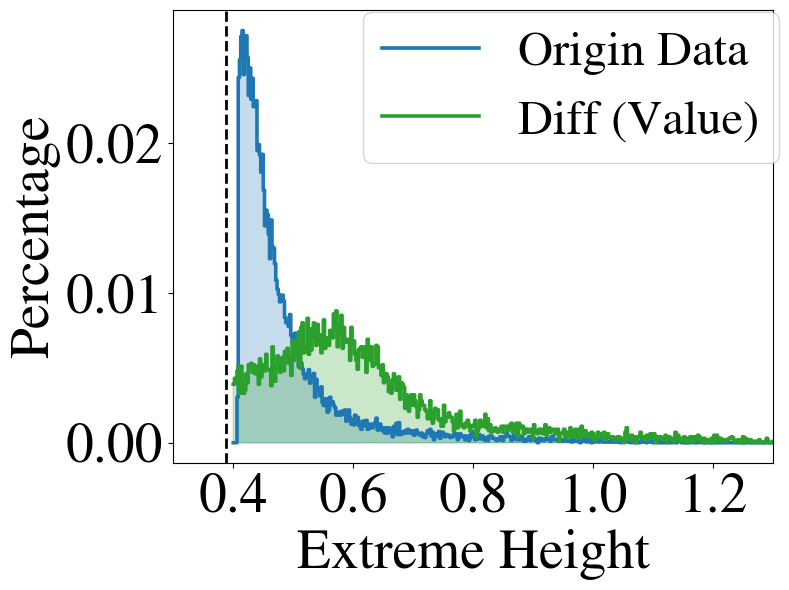

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: xlabel='Extreme Height', ylabel='Percentage'>)

In [41]:
savepath = "../Data-Driven Analysis/Plot/extreme height"
plot_event_peak_amplitude_hist(ori_peak,gen_peak,u_global = u_global,bins=1000,xlim = (0.3,1.3),savepath = savepath)

In [34]:
def plot_event_width_hist(
    ori_w, gen_w,
    xlim=None,
    title="Event width distribution",
    savepath=None, dpi=300
):
    wmax = 1
    if ori_w.size > 0:
        wmax = max(wmax, int(np.max(ori_w)))
    if gen_w.size > 0:
        wmax = max(wmax, int(np.max(gen_w)))
    width_bins = np.arange(0.5, wmax + 1.5, 1.0)

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.hist(ori_w, bins=width_bins, alpha=0.6, label="Origin Data", color="tab:blue")
    ax.hist(gen_w, bins=width_bins, alpha=0.6, label="Diff (Value)", color="tab:green")

    # ax.set_title(title)
    ax.set_xlabel("Extreme width", fontsize=40)   # 你也可以改成 "Event width" 更中性
    ax.set_ylabel("Count", fontsize=40)

    ax.tick_params(axis="x", labelsize=40)
    ax.tick_params(axis="y", labelsize=40)

    # x ticks: integer widths
    xticks = np.arange(1, wmax + 1, 3,  dtype=np.int32)
    ax.set_xticks(xticks)

    if xlim is not None:
        ax.set_xlim(float(xlim[0]), float(xlim[1]))

    # 如果你也想固定 y 轴刻度，像上一张那样加：
    # ax.set_yticks([100,200,300,400,500,600])

    ax.legend(loc="upper right",bbox_to_anchor=(1.05, 1.05), fontsize = 35)
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()
    return fig, ax

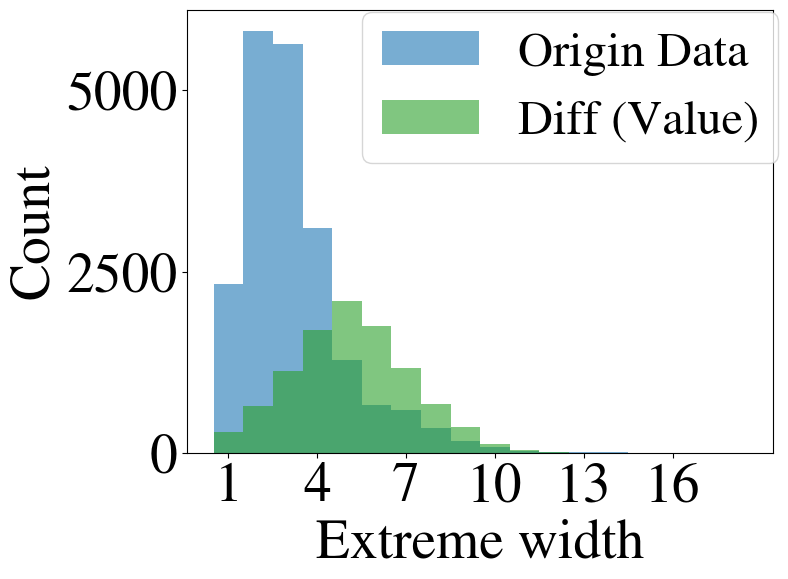

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: xlabel='Extreme width', ylabel='Count'>)

In [35]:
savepath = "../Data-Driven Analysis/Plot/extreme width"
plot_event_width_hist(ori_w, gen_w, savepath = savepath)

In [32]:
def plot_event_count_pmf(ori_cnt, gen_cnt, savepath=None, dpi=300):
    ori_cnt = np.asarray(ori_cnt).astype(int)
    gen_cnt = np.asarray(gen_cnt).astype(int)

    cmax = int(max(ori_cnt.max() if ori_cnt.size else 0,
                   gen_cnt.max() if gen_cnt.size else 0))
    ks = np.arange(0, cmax + 1, dtype=int)

    # >>> count instead of probability
    ori_c = np.array([(ori_cnt == k).sum() for k in ks], dtype=int)
    gen_c = np.array([(gen_cnt == k).sum() for k in ks], dtype=int)

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(ks, ori_c, marker="o", linewidth=2.6, label="Origin Data", color="tab:blue")
    ax.plot(ks, gen_c, marker="o", linewidth=2.6, label="Diff (Value)", color="tab:green")

    ax.set_xlabel("Extreme events per sample", fontsize=40)
    ax.set_ylabel("Count", fontsize=40)

    ax.tick_params(axis="x", labelsize=40)
    ax.tick_params(axis="y", labelsize=40)
    ax.set_xticks(ks)
    ax.set_yticks([1000,2000,3000,4000,5000],['1k','2k','3k','4k','5k'])

    ax.legend(loc="upper right",bbox_to_anchor=(1.05, 1.05), fontsize = 35)
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()
    return fig, ax

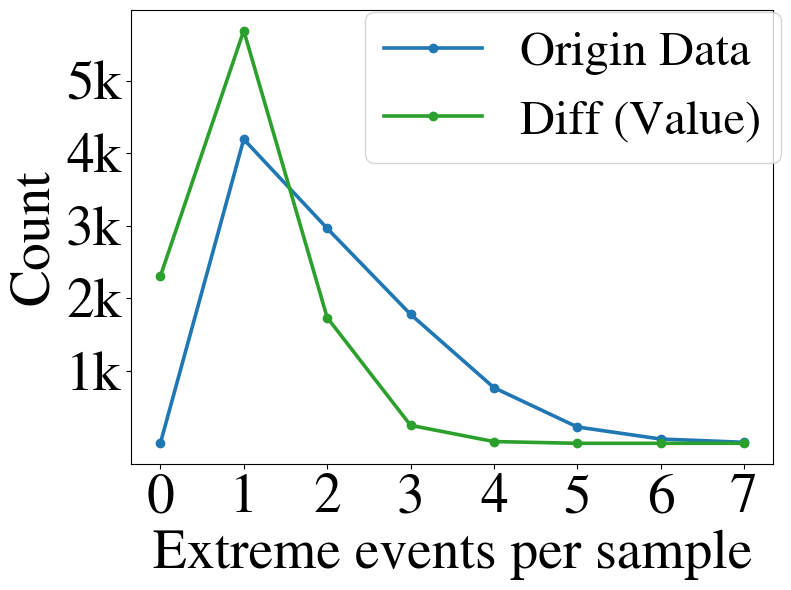

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: xlabel='Extreme events per sample', ylabel='Count'>)

In [33]:
savepath = "../Data-Driven Analysis/Plot/extreme count"
plot_event_count_pmf(ori_cnt, gen_cnt,savepath = savepath)